In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, dayofweek, hour
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [22]:
print(spark)

In [23]:

data_path = "gs://group_10_big_data/US_Accidents_March23.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [24]:

# Data preprocessing
df = df.withColumn("Start_Time", to_timestamp(col("Start_Time")))
df = df.withColumn("End_Time", to_timestamp(col("End_Time")))
df = df.withColumn("Day_of_Week", dayofweek(col("Start_Time")))
df = df.withColumn("Hour_of_Day", hour(col("Start_Time")))

# Handle null values
df = df.na.drop()

indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Index").setHandleInvalid("keep")
encoder = OneHotEncoder(inputCols=["Weather_Index"], outputCols=["Weather_Cond"])

assembler = VectorAssembler(
    inputCols=["Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Distance(mi)", "Day_of_Week", "Hour_of_Day", "Weather_Cond"],
    outputCol="features",
    handleInvalid="skip")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [25]:
# Initialize multiple classifiers
classifiers = [
    RandomForestClassifier(labelCol="Severity", featuresCol="scaledFeatures"),
#     LogisticRegression(labelCol="Severity", featuresCol="scaledFeatures"),
    # GBTClassifier(labelCol="Severity", featuresCol="scaledFeatures")
]


In [26]:

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.7, 0.3])


In [27]:

# Loop through classifiers
for classifier in classifiers:
    # Define the pipeline
    pipeline = Pipeline(stages=[indexer, encoder, assembler, scaler, classifier])

    # Define the parameter grid for hyperparameter tuning
    paramGrid = (ParamGridBuilder()
        .addGrid(classifier.maxIter, [10, 20]) if not isinstance(classifier, RandomForestClassifier)
        else ParamGridBuilder().addGrid(classifier.numTrees, [10, 20, 30])
        ).build()

    # CrossValidator for model tuning
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy"),
                              numFolds=3)

    # Fit the model
    cvModel = crossval.fit(train_data)

    # Make predictions on the test data
    predictions = cvModel.transform(test_data)

    # Evaluate the model
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    #print(f"Model Accuracy for {classifier._class.name_}: {accuracy}")
    print(f"Model Accuracy : {accuracy}")




Model Accuracy : 0.9420933721532795


In [28]:
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
# accuracy = accuracy_evaluator.evaluate(predictions)
# print(f"Model Accuracy : {accuracy}")

# Calculate Precision and Recall
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedRecall")
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

print(f"Model Precision: {precision}")
print(f"Model Recall: {recall}")

Model Precision: 0.8875399218551375
Model Recall: 0.9420933721532795


In [29]:
# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall if precision + recall != 0 else 1)

print(f"Model F1 Score: {f1_score}")

Model F1 Score: 0.9140033477083392


In [30]:
import pandas as pd
predictions_pd = predictions.select(['probability', 'Severity']).toPandas()

# Extract the probabilities for the positive class (assuming binary classification)
predictions_pd['probability'] = predictions_pd['probability'].apply(lambda x: x[1])

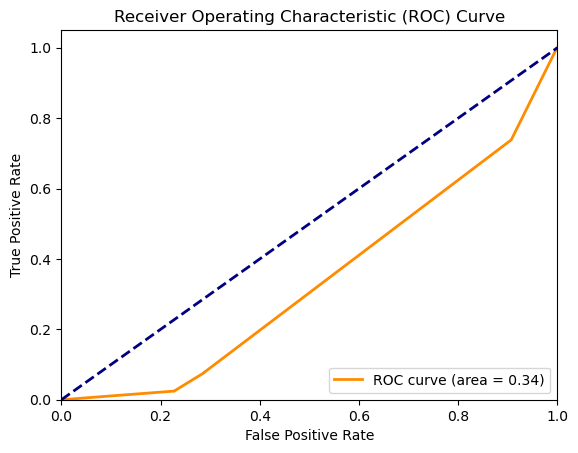

In [20]:
# Convert the 'Severity' levels to a binary problem
y_true_binary = (y_true == 2).astype(int)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()